# Data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
from matplotlib import pyplot as plt
import seaborn as sns
import linearmodels
from linearmodels.panel import PanelOLS
from statsmodels.api import OLS
from collections import OrderedDict

merged3_df = pd.read_parquet("merged3_df.parquet") # Full dataset
merged4_df = pd.read_parquet("merged4_df.parquet") # Excluding Italy, Japan and the US

# Generate the lag_debt variables
merged3_df['lag_debt'] = merged3_df['debt'].shift(1)
merged3_df['lag_debt_sq'] = merged3_df['lag_debt'].apply(lambda x: x**2)
merged3_df['lag_debt_cu'] = merged3_df['lag_debt'].apply(lambda x: x**3)

## Figure 1

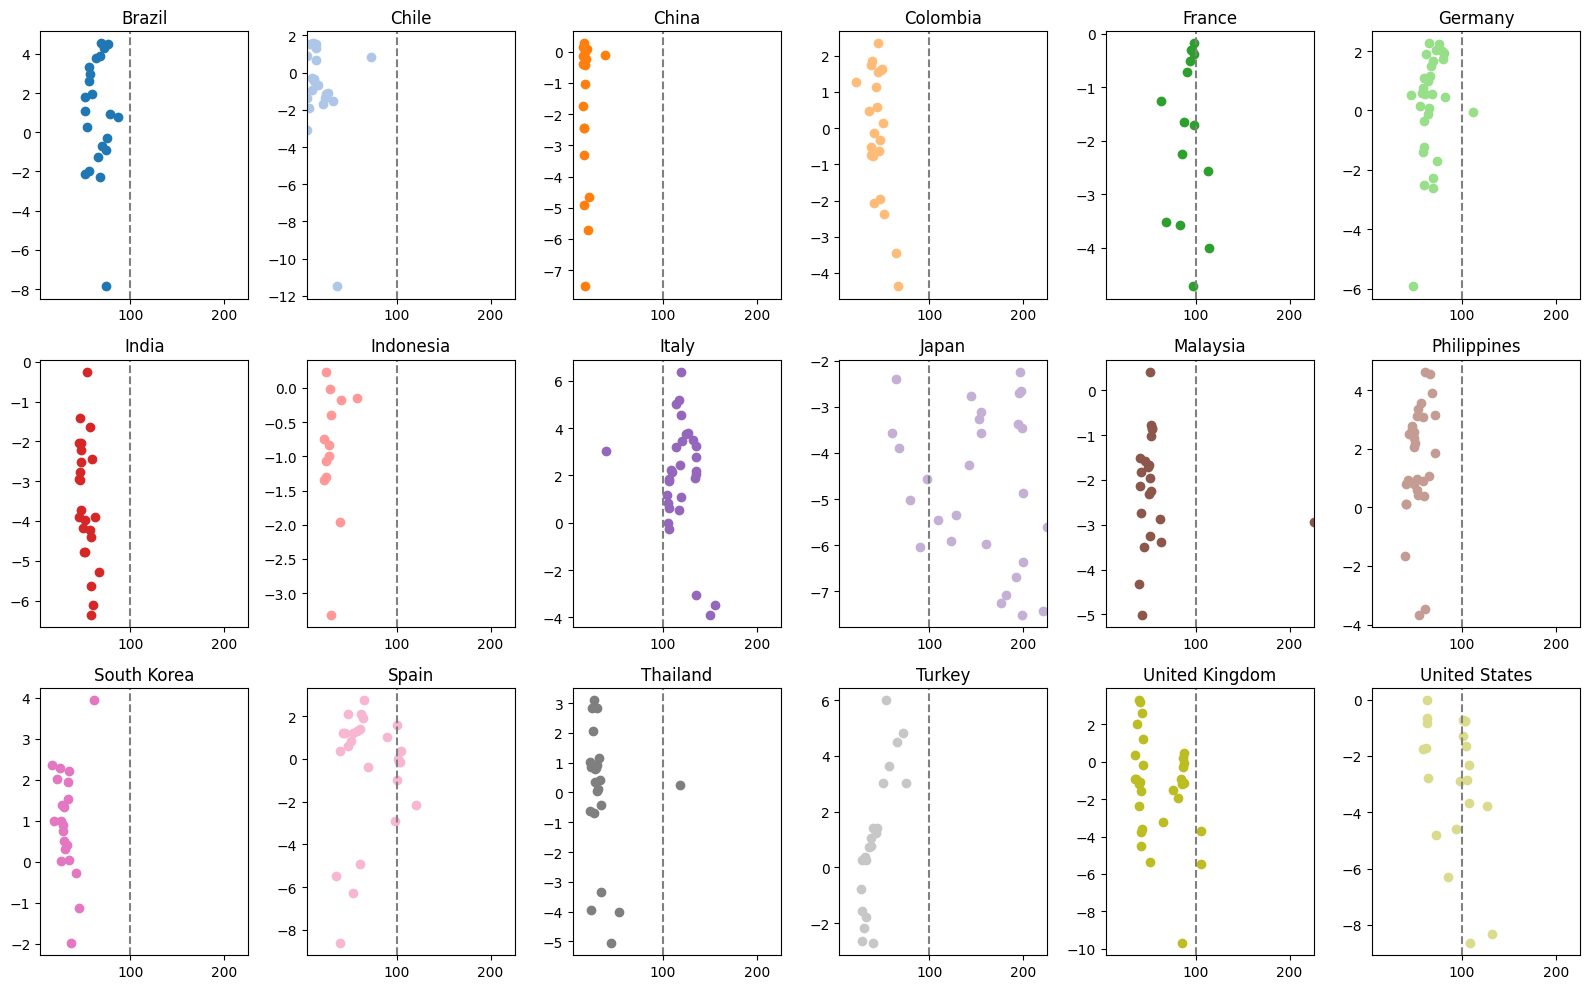

In [2]:
# create separate datasets for each country
countries = merged3_df['country'].unique()
datasets = {country: merged3_df[merged3_df['country'] == country] for country in countries}
# define a color map for each country
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(len(countries))]
# combine countries and colors into a dictionary
country_colors = {country: colors[i] for i, country in enumerate(countries)}
# plot scatterplots for each country's dataset
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))
x_min, x_max = merged3_df['lag_debt'].min(), merged3_df['lag_debt'].max() # set the x-axis range
for i, country in enumerate(countries):
    row = i // ncols
    col = i % ncols
    axs[row][col].scatter(datasets[country]['lag_debt'], datasets[country]['pb'], color=colors[i])
    axs[row][col].axvline(x=100, linestyle='--', color='grey') # add the dotted line at x=100
    country_title = country.replace("_", " ").title()
    axs[row][col].set_title(country_title)
    axs[row][col].set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

## Figure 2

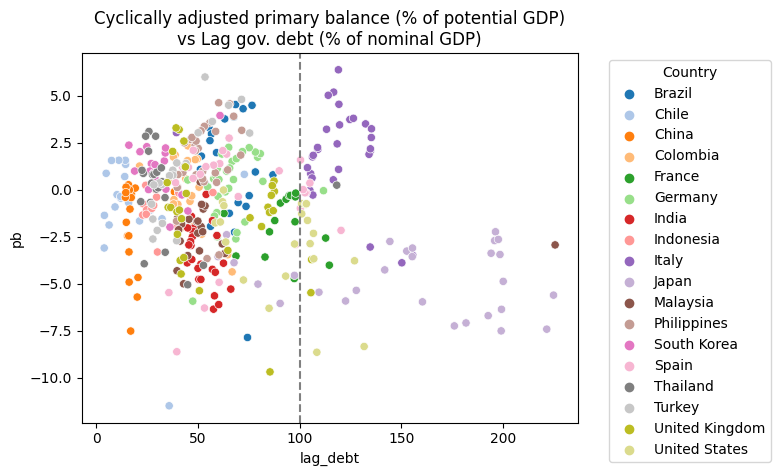

In [3]:
# Create the scatterplot
ax = sns.scatterplot(x=merged3_df['lag_debt'],  
                     y=merged3_df['pb'],
                     hue=merged3_df['country'].str.replace("_", " ").str.title(), palette='tab20')
# Set the plot title
ax.set(title='Cyclically adjusted primary balance (% of potential GDP)\nvs Lag gov. debt (% of nominal GDP)')
# add dotted line at x=100
plt.axvline(x=100, linestyle='--', color='grey')
# Remove the legend from the plot
# Create the legend separately
legend = plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
# Display the plot
plt.show()

# Result

## Result from the models (POLS, FE, TWFE)

### Pooled OLS

In [4]:
# Drop rows with NaN due to creation of lag variables
merged3_df = merged3_df.dropna()
y_var_name = 'pb'
X_var_names = ['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage']
# Carve out the y and x vector from the data panel
pooled_y=merged3_df[y_var_name]
pooled_X=merged3_df[X_var_names]
# Build the OLS regression model
pooled_olsr_model = sm.OLS(endog=pooled_y, exog=pooled_X)
# Train the model on the (y, X) data set and fetch the training results
pooled_olsr_model_results = pooled_olsr_model.fit()
print(pooled_olsr_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     pb   R-squared (uncentered):                   0.199
Model:                            OLS   Adj. R-squared (uncentered):              0.179
Method:                 Least Squares   F-statistic:                              10.09
Date:                Thu, 17 Aug 2023   Prob (F-statistic):                    3.38e-15
Time:                        15:35:45   Log-Likelihood:                         -991.30
No. Observations:                 416   AIC:                                      2003.
Df Residuals:                     406   BIC:                                      2043.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### FE (country)

In [5]:
unit_col_name='country'
time_period_col_name='year'
# Create the dummy variables, one for each country
df_dummies = pd.get_dummies(merged3_df[unit_col_name])
# Join the dummies Dataframe to the panel data set
df_panel_with_dummies =pd.concat([merged3_df, df_dummies], axis=1)
# Reset index to make year a column instead of index
df_panel_with_dummies = df_panel_with_dummies.reset_index()

# Get column names of dummy countries
unique_country = df_panel_with_dummies['country'].unique()
# create a panel data object
# `entity_idx` is the name of the column containing country names
# `time_idx` is the name of the column containing year values
data = df_panel_with_dummies.set_index(['country', 'year'])

# define variable names
# add constant term to x variables
y_var_name = data['pb']
X_var_names = data[['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage']]

# run fixed effects regression with country FE only
model = PanelOLS(y_var_name, X_var_names, entity_effects=True, time_effects=False, drop_absorbed=True)
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.2491
Estimator:                   PanelOLS   R-squared (Between):             -1.5450
No. Observations:                 416   R-squared (Within):               0.2491
Date:                Thu, Aug 17 2023   R-squared (Overall):             -0.6602
Time:                        15:35:45   Log-likelihood                   -847.92
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.873
Entities:                          18   P-value                           0.0000
Avg Obs:                       23.111   Distribution:                  F(10,388)
Min Obs:                       13.000                                           
Max Obs:                       30.000   F-statistic (robust):             11.586
                            

### TWFE

In [6]:
model1 = PanelOLS(y_var_name, X_var_names, entity_effects=True, time_effects=True, drop_absorbed=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)
print(results1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.1107
Estimator:                   PanelOLS   R-squared (Between):             -2.2325
No. Observations:                 416   R-squared (Within):               0.0082
Date:                Thu, Aug 17 2023   R-squared (Overall):             -1.0119
Time:                        15:35:45   Log-likelihood                   -773.83
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6143
Entities:                          18   P-value                           0.0000
Avg Obs:                       23.111   Distribution:                   F(8,361)
Min Obs:                       13.000                                           
Max Obs:                       30.000   F-statistic (robust):             11.871
                            

/tmp/ipykernel_902751/1769964197.py:2: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

fuel_yoy, non_fuel_yoy

  results1 = model1.fit(cov_type='clustered', cluster_entity=True)


## Figures of fitted POLS
### Figure 3a (Fitted POLS with Full Sample)

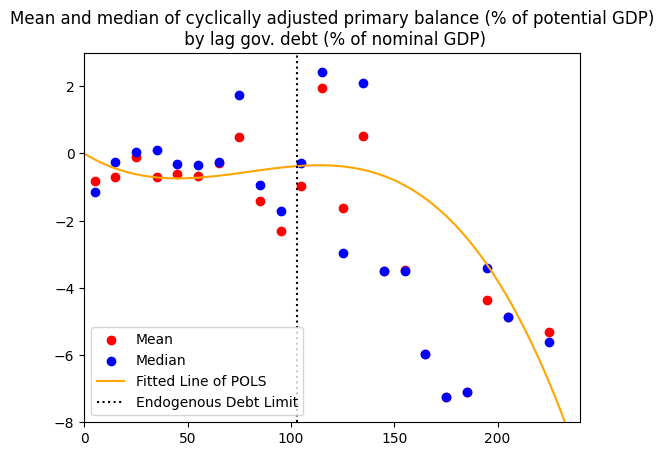

In [7]:
bins1 = np.arange(0, 231, 10)
# Create bins for primary balance
bins = pd.cut(merged3_df['lag_debt'], bins=bins1)

# Group the DataFrame by the bins and calculate the mean and median of primary balance for each bin
meanspb = merged3_df.groupby(bins)['pb'].mean()
medianspb = merged3_df.groupby(bins)['pb'].median()

lag_debt_coef = pooled_olsr_model_results.params['lag_debt']
lag_debt_sq_coef = pooled_olsr_model_results.params['lag_debt_sq']
lag_debt_cu_coef = pooled_olsr_model_results.params['lag_debt_cu']

# define the x-values
x = np.linspace(0, 250, 100)
# define the equation
y = lag_debt_coef*x + lag_debt_sq_coef*x**2 + lag_debt_cu_coef*x**3

# Plot a scatterplot for the calculated mean and median of primary balance 
fig, ax = plt.subplots()
ax.scatter([interval.mid for interval in meanspb.index], meanspb, marker='o', color='red', label='Mean')
ax.scatter([interval.mid for interval in medianspb.index], medianspb, marker='o', color='blue', label='Median')
ax.plot(x, y, label='Fitted Line of POLS', color='orange')
ax.axvline(x=103, color='black', linestyle='dotted', label='Endogenous Debt Limit')
ax.legend()
ax.set_title('Mean and median of cyclically adjusted primary balance (% of potential GDP)\n by lag gov. debt (% of nominal GDP)')
plt.xlim([0,240])
plt.ylim([-8,3])
plt.show()

### Figure 3b (Fitted POLS excluding Italy, Japan, the US)

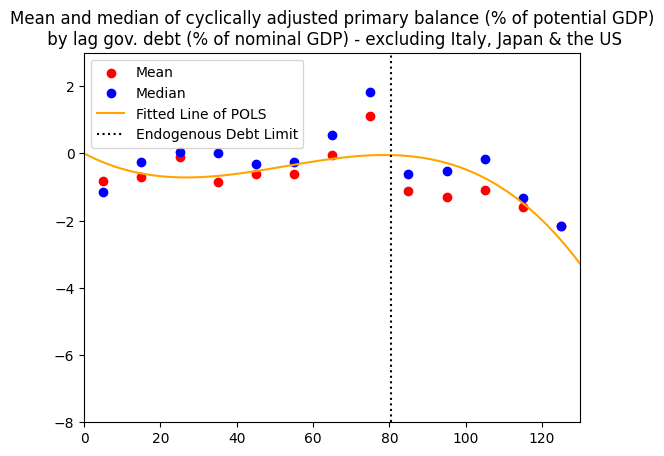

In [8]:
# Generate the lag_debt variables
merged4_df['lag_debt'] = merged4_df['debt'].shift(1)
merged4_df['lag_debt_sq'] = merged4_df['lag_debt'].apply(lambda x: x**2)
merged4_df['lag_debt_cu'] = merged4_df['lag_debt'].apply(lambda x: x**3)

# Drop rows with NaN due to creation of lag variables
merged4_df = merged4_df.dropna()

# POLS
y_var_name = 'pb'
X_var_names = ['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage']

# Carve out the y and x vector from the data panel
pooled_y=merged4_df[y_var_name]
pooled_X=merged4_df[X_var_names]

# Build the OLS regression model
pooled_olsr_model = sm.OLS(endog=pooled_y, exog=pooled_X)

# Train the model on the (y, X) data set and fetch the training results
pooled_olsr_model_results = pooled_olsr_model.fit()

bins1 = np.arange(0, 231, 10)
# Create bins for primary balance
bins = pd.cut(merged4_df['lag_debt'], bins=bins1)
# Group the DataFrame by the bins and calculate the mean and median of primary balance for each bin
meanspb = merged4_df.groupby(bins)['pb'].mean()
medianspb = merged4_df.groupby(bins)['pb'].median()

lag_debt_coef = pooled_olsr_model_results.params['lag_debt']
lag_debt_sq_coef = pooled_olsr_model_results.params['lag_debt_sq']
lag_debt_cu_coef = pooled_olsr_model_results.params['lag_debt_cu']

# define the x-values
x = np.linspace(0, 250, 100)
# define the equation
# y = -9.726e-06*x**3 + 0.0016*x**2 - 0.0683*x
y = lag_debt_coef*x + lag_debt_sq_coef*x**2 + lag_debt_cu_coef*x**3

# Plot a scatterplot for the calculated mean and median of primary balance 
fig, ax = plt.subplots()
ax.scatter([interval.mid for interval in meanspb.index], meanspb, marker='o', color='red', label='Mean')
ax.scatter([interval.mid for interval in medianspb.index], medianspb, marker='o', color='blue', label='Median')
ax.plot(x, y, label='Fitted Line of POLS', color='orange')
ax.set_title('Mean and median of cyclically adjusted primary balance (% of potential GDP)\n by lag gov. debt (% of nominal GDP) - excluding Italy, Japan & the US')
ax.axvline(x=80.3, color='black', linestyle='dotted', label='Endogenous Debt Limit')
plt.xlim([0,130])
plt.ylim([-8,3])
ax.legend()
plt.show()

## Country-specific OLS
### Figure 4: Cubic

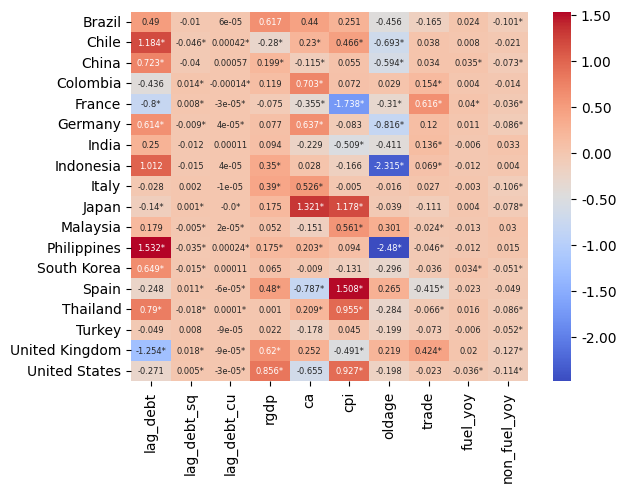

In [9]:
# Create an ordered dictionary to store data for each country
mod_data = OrderedDict()

# Loop through each country in merged1_df
for country in merged3_df['country'].unique():
    
    # Filter the data for the current country
    country_data = merged3_df[merged3_df['country'] == country]
    
    # Define the dependent variable and exogenous variables for the current country
    dependent_var = 'pb'
    exog_vars = ['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'ca', 'cpi', 'oldage', 
                 'trade', 'fuel_yoy', 'non_fuel_yoy']
    
    # Drop rows with missing values for all variables
    country_data = country_data.dropna(subset=[dependent_var] + exog_vars)
    
    # Define the dependent and exogenous variables
    y = country_data[dependent_var]
    X = country_data[exog_vars]
    
    # Fit the OLS model for the current country
    ols_model = OLS(y, X)
    ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    
    # Store the data and results for the current country in the ordered dictionary
    mod_data[country] = {"dependent": y, "exog": X, "results": ols_result}
    
# Create an empty DataFrame to store the coefficients
pd.options.display.float_format = '{:.5f}'.format

empty_df = pd.DataFrame(columns=["lag_debt", "lag_debt_sq", "lag_debt_cu", "rgdp", "ca", "cpi", "oldage", 
                                 "trade", "fuel_yoy", "non_fuel_yoy"])
coef_df = empty_df.copy()
sig_df = empty_df.copy()

# Loop through each country in the mod_data dictionary and extract the coefficients and significance
for country, data in mod_data.items():
    coef_df.loc[country] = data["results"].params.tolist()
    sig_df.loc[country] = ["*" if pval < 0.05 else "" for pval in data["results"].pvalues.tolist()]

# alternative way to show the coef
coef_df1 = coef_df.round({"lag_debt_cu": 5, "lag_debt": 3, "lag_debt_sq": 3, "rgdp": 3, "ca": 3, 
                           "cpi": 3, "oldage": 3, "trade": 3, "fuel_yoy": 3, "non_fuel_yoy": 3})

result_concat1 = coef_df1.apply(lambda x: x.astype(str) + sig_df[x.name].astype(str))
result_concat1.index = result_concat1.index.str.replace("_", " ").str.title()

coef_df_name = coef_df.copy()
coef_df_name.index = coef_df.index.str.replace("_", " ").str.title()
# Create a heatmap using the cube root data, but annotate with original data
sns.heatmap(coef_df_name, fmt='', annot = result_concat1, cmap='coolwarm', annot_kws={'size':6}, cbar_kws={"format":"%.2f"})
# Show the plot
plt.show()

### Figure 5: Quadratic

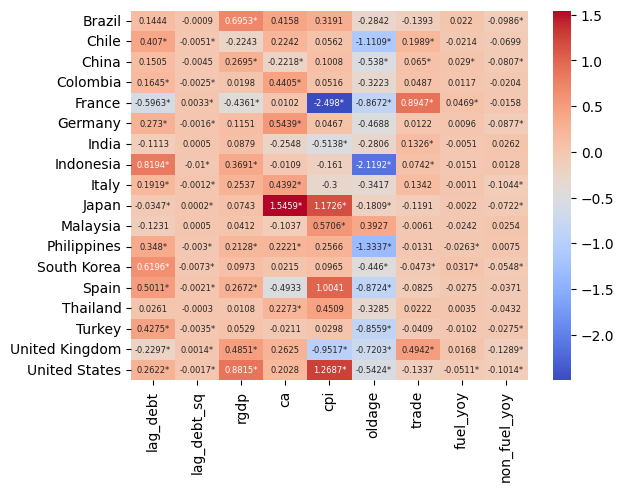

In [10]:
# Create an ordered dictionary to store data for each country
mod_data2 = OrderedDict()

# Loop through each country in merged1_df
for country in merged3_df['country'].unique():
    
    # Filter the data for the current country
    country_data = merged3_df[merged3_df['country'] == country]
    
    # Define the dependent variable and exogenous variables for the current country
    dependent_var = 'pb'
    exog_vars2 = ['lag_debt', 'lag_debt_sq', 'rgdp', 'ca', 'cpi', 'oldage', 
                 'trade', 'fuel_yoy', 'non_fuel_yoy']
    
    # Drop rows with missing values for all variables
    country_data = country_data.dropna(subset=[dependent_var] + exog_vars)
    
    # Define the dependent and exogenous variables
    y = country_data[dependent_var]
    X = country_data[exog_vars2]
    
    # Fit the OLS model for the current country
    ols_model2 = OLS(y, X)
    ols_result2 = ols_model2.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    
    # Store the data and results for the current country in the ordered dictionary
    mod_data2[country] = {"dependent": y, "exog": X, "results": ols_result2}

# Create an empty DataFrame to store the coefficients and significance
empty_df1 = pd.DataFrame(columns=["lag_debt", "lag_debt_sq", "rgdp", "ca", "cpi", "oldage", 
                                 "trade", "fuel_yoy", "non_fuel_yoy"])
coef_df2 = empty_df1.copy() 
sig_df2 = empty_df1.copy()

# Loop through each country in the mod_data dictionary and extract the coefficients, standard errors, p-values, and significance
for country, data in mod_data2.items():
    coef_df2.loc[country] = data["results"].params.tolist()
    sig_df2.loc[country] = ["*" if pval < 0.05 else "" for pval in data["results"].pvalues.tolist()]

coef_df12 = coef_df2.round(4)

result_concat12 = coef_df12.apply(lambda x: x.astype(str) + sig_df2[x.name].astype(str))
result_concat12.index = result_concat12.index.str.replace("_", " ").str.title()

coef_df12_name = coef_df12.copy()
coef_df12_name.index = coef_df12_name.index.str.replace("_", " ").str.title()

# Create a heatmap using the cube root data, but annotate with original data
sns.heatmap(coef_df12_name, fmt='', annot = result_concat12, cmap='coolwarm', annot_kws={'size':6})

# Show the plot
plt.show()

### Figure 6a: cubic threshold  

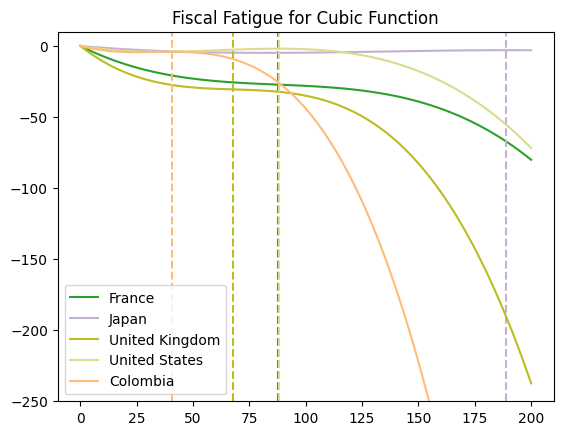

In [11]:
# Figure 6 (Cubic)

from scipy.signal import argrelextrema
import math

# Define the cubic function
def cubic_func(x, coefficients):
    a = coefficients['lag_debt_cu']
    b = coefficients['lag_debt_sq']
    c = coefficients['lag_debt']
    d = coefficients['constant']
    return np.outer(a, x**3) + np.outer(b, x**2) + np.outer(c, x) + np.outer(d, np.ones_like(x))

# Define the coefficients of the quadratic function as a pandas dataframe
coefficients = coef_df.loc[['france','japan','united_kingdom','united_states','colombia']]
coefficients = coefficients[['lag_debt_cu','lag_debt_sq','lag_debt']]

# round up only columns A and B in the dataframe to 6 decimal places
coefficients[['lag_debt_sq', 'lag_debt']] = coefficients[['lag_debt_sq', 'lag_debt']].applymap(lambda x: math.ceil(x * 10**5) / 10**5)


# Create a new column with constant values
const_col = pd.Series([0]*len(coefficients), name='constant', index=coefficients.index)

# Concatenate the new column with the original DataFrame
coefficients = pd.concat([coefficients, const_col], axis=1)

# Define a range of x-values over which to evaluate the function
x_values = np.linspace(0, 200, 100000)

# Evaluate the function at the x-values
y_values = cubic_func(x_values, coefficients)

# Find the local maxima of the function
maxima_indices = []
for i in range(y_values.shape[0]):
    maxima_idx = argrelextrema(y_values[i], np.greater)[0]
    if len(maxima_idx) == 0:
        maxima_indices.append(np.nan)
    else:
        maxima_indices.append(maxima_idx)

# Find the x-values of the local maxima
maxima_x_values = []
for i in range(len(maxima_indices)):
    if np.isnan(maxima_indices[i]):
        maxima_x_values.append(np.nan)
    else:
        maxima_x_values.append(x_values[maxima_indices[i]])

# Store the local maxima as a column in the coefficients DataFrame
coefficients['local_maxima'] = maxima_x_values
coefficients.local_maxima = coefficients.local_maxima.astype("float")

from scipy.signal import argrelextrema
import math

# Define the cubic function
def cubic_func(x, coefficients):
    a = coefficients['lag_debt_cu']
    b = coefficients['lag_debt_sq']
    c = coefficients['lag_debt']
    d = coefficients['constant']
    return np.outer(a, x**3) + np.outer(b, x**2) + np.outer(c, x) + np.outer(d, np.ones_like(x))

# Define the coefficients of the quadratic function as a pandas dataframe
coefficients = coef_df.loc[['france','japan','united_kingdom','united_states','colombia']]
coefficients = coefficients[['lag_debt_cu','lag_debt_sq','lag_debt']]

# round up only columns A and B in the dataframe to 6 decimal places
coefficients[['lag_debt_sq', 'lag_debt']] = coefficients[['lag_debt_sq', 'lag_debt']].applymap(lambda x: math.ceil(x * 10**5) / 10**5)

# Create a new column with constant values
const_col = pd.Series([0]*len(coefficients), name='constant', index=coefficients.index)
# Concatenate the new column with the original DataFrame
coefficients = pd.concat([coefficients, const_col], axis=1)
# Define a range of x-values over which to evaluate the function
x_values = np.linspace(0, 200, 100000)
# Evaluate the function at the x-values
y_values = cubic_func(x_values, coefficients)
# Find the local maxima of the function
maxima_indices = []
for i in range(y_values.shape[0]):
    maxima_idx = argrelextrema(y_values[i], np.greater)[0]
    if len(maxima_idx) == 0:
        maxima_indices.append(np.nan)
    else:
        maxima_indices.append(maxima_idx)
# Find the x-values of the local maxima
maxima_x_values = []
for i in range(len(maxima_indices)):
    if np.isnan(maxima_indices[i]):
        maxima_x_values.append(np.nan)
    else:
        maxima_x_values.append(x_values[maxima_indices[i]])
# Store the local maxima as a column in the coefficients DataFrame
coefficients['local_maxima'] = maxima_x_values
coefficients.local_maxima = coefficients.local_maxima.astype("float")
# Define the coefficients of multiple cubic functions
coefficients1 = coefficients.drop("local_maxima", axis=1)
df = coefficients1.values.tolist()
# Create an empty DataFrame to store the inflection points
inflexion_points = pd.DataFrame(columns=['function', 'x', 'y'])
# Loop over each group of coefficients and find the inflection points
for i, coeffs in enumerate(df):
    # Calculate the values of the function at each x value
    y_values = np.polyval(coeffs, x_values)

    # Calculate the second derivative of the function
    second_derivative = np.polyder(np.polyder(coeffs))

    # Calculate the values of the second derivative at each x value
    second_derivative_values = np.polyval(second_derivative, x_values)

    # Find the indices of the inflection points
    inflexion_indices = np.where(np.diff(np.sign(second_derivative_values)) != 0)[0]

    # Get the x and y values of the inflection points
    inflexion_x = x_values[inflexion_indices]
    inflexion_y = y_values[inflexion_indices]

    # Create a DataFrame to store the inflection points for this function
    temp = pd.DataFrame({'function': i, 'x': inflexion_x, 'y': inflexion_y})

    # Concatenate the DataFrames vertically using the concat() function
    inflexion_points = pd.concat([inflexion_points, temp], ignore_index=True)

inflexion_points = inflexion_points.set_index(coefficients.index)
inflexion_points
coefficients = coefficients.join(inflexion_points['x'], how = 'left')
# Define x range
x = np.linspace(0, 200, 100)
# Calculate y values for each row
y_values = np.zeros((len(coefficients), len(x)))
for i in range(len(coefficients)):
    for j in range(len(x)):
        y_values[i][j] = coefficients.iloc[i]['lag_debt_cu'] * x[j]**3 + coefficients.iloc[i]['lag_debt_sq'] * x[j]**2 + coefficients.iloc[i]['lag_debt'] * x[j] 
# set the color for the countries
colors = {'france': 'darkblue', 'japan':'deeppink', 'united_kingdom':'lawngreen', 'united_states':'lightcoral', 'colombia':'darkorange'}
# Set the y-axis limit
plt.ylim([-250, 10])
# Plot functions and vertical lines for each country
for i in range(len(coefficients)):
    country = coefficients.index[i]
    country_name = coefficients.index[i].replace("_", " ").title()
    color = country_colors[country]
    plt.plot(x, y_values[i], label=country_name, color=color)
    if pd.isna(coefficients.local_maxima[i]):
        plt.axvline(x=coefficients.x[i], linestyle='--', color=color)
    else:
        plt.axvline(x=coefficients.local_maxima[i], linestyle='--', color=color)
# Add legend and title
plt.legend()
plt.title('Fiscal Fatigue for Cubic Function')
# Show plot
plt.show()

### Figure 6b: quadratic threshold  

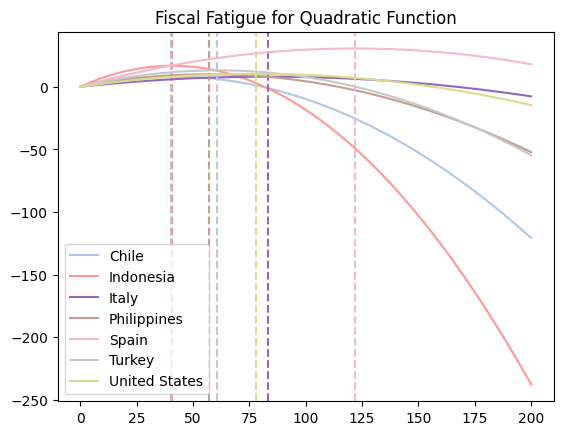

In [12]:


# Define the quadratic function
def quadratic_func(x, coefficients):
    a = coefficients['lag_debt_sq']
    b = coefficients['lag_debt']
    c = coefficients['constant']
    return np.outer(a, x**2) + np.outer(b, x) + np.outer(c, np.ones_like(x))
# Define the coefficients of the quadratic function as a pandas dataframe
coefficients = coef_df2.loc[['chile', 'indonesia', 'italy', 'philippines', 'spain', 'turkey', 'united_states']]
coefficients = coefficients[['lag_debt_sq','lag_debt']]
# Create a new column with constant values
const_col = pd.Series([0]*len(coefficients), name='constant', index=coefficients.index)
# Concatenate the new column with the original DataFrame
coefficients = pd.concat([coefficients, const_col], axis=1)
# Define a range of x-values over which to evaluate the function
x_values = np.linspace(0, 200, 1000)
# Evaluate the function at the x-values
y_values = quadratic_func(x_values, coefficients)
# Find the turning points for each set of y-values
turning_points = []
for i in range(y_values.shape[0]):
    dy_dx = np.gradient(y_values[i], x_values)
    tp = np.where(np.diff(np.sign(dy_dx)))[0]
    if len(tp) > 0:
        # Find the corresponding x-values of the turning points
        x_tp = x_values[tp]
    else:
        x_tp = np.nan
    turning_points.append(x_tp)
# Store the turning points as a column in the coefficients DataFrame
coefficients['turning_points'] = turning_points
coefficients.turning_points = coefficients.turning_points.astype("float")
# Define x range
x = np.linspace(0, 200, 100)
# Calculate y values for each row
y_values = np.zeros((len(coefficients), len(x)))
for i in range(len(coefficients)):
    for j in range(len(x)):
        y_values[i][j] = coefficients.iloc[i]['lag_debt_sq'] * x[j]**2 + coefficients.iloc[i]['lag_debt'] * x[j] 
# set the color for the countries
colors = {'chile': 'blue', 'indonesia':'orange', 'italy':'green', 'philippines':'red', 'spain':'purple', 'turkey':'brown', 'united_states':'lightcoral'}
# Plot functions and vertical lines for each country
for i in range(len(coefficients)):
    country = coefficients.index[i]
    color = country_colors[country]
    country_name = coefficients.index[i].replace("_", " ").title()
    plt.plot(x, y_values[i], label=country_name, color=color)
    plt.axvline(x=coefficients.turning_points[i], linestyle='--', color=color)
# Add legend and title
plt.legend()
plt.title('Fiscal Fatigue for Quadratic Function')
# Show plot
plt.show()

## Robustness check 1: Creating a crisis dummy for finanial crisis years 2007 - 2009

In [13]:
merged3_df['crisis'] = ((merged3_df.index.year >= 1997) & (merged3_df.index.year <= 1998) |
                        (merged3_df.index.year >= 2007) & (merged3_df.index.year <= 2009)).astype(int)

# Create interaction term of crisis x debt
merged3_df['crisis_debt'] = merged3_df['crisis'] * merged3_df['debt']

# POLS with crisis dummy interaction
y_var_name_crisis = ['pb']
X_var_names_crisis = ['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage', 'crisis', 'crisis_debt']
# Carve out the y and x vector from the data panel
pooled_y_crisis=merged3_df[y_var_name_crisis]
pooled_X_crisis=merged3_df[X_var_names_crisis]
# Build the OLS regression model
pooled_olsr_model_crisis = sm.OLS(endog=pooled_y_crisis, exog=pooled_X_crisis)
# Train the model on the (y, X) data set and fetch the training results
pooled_olsr_model_results_crisis = pooled_olsr_model_crisis.fit()
print(pooled_olsr_model_results_crisis.summary())

                                 OLS Regression Results                                
Dep. Variable:                     pb   R-squared (uncentered):                   0.200
Model:                            OLS   Adj. R-squared (uncentered):              0.177
Method:                 Least Squares   F-statistic:                              8.443
Date:                Thu, 17 Aug 2023   Prob (F-statistic):                    2.53e-14
Time:                        15:35:47   Log-Likelihood:                         -990.94
No. Observations:                 416   AIC:                                      2006.
Df Residuals:                     404   BIC:                                      2054.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [14]:
# Country FE with crisis dummy interaction

# create a panel data object
# `entity_idx` is the name of the column containing country names
# `time_idx` is the name of the column containing year values
merged3_df = merged3_df.reset_index(drop=False)
data_crisis = merged3_df.set_index(['country', 'year'])
# define variable names
# add constant term to x variables
y_var_name_crisis = data_crisis['pb']
X_var_names_crisis = data_crisis[['lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage', 'crisis', 'crisis_debt']]
fe_model_crisis = PanelOLS(y_var_name_crisis, X_var_names_crisis, entity_effects=True, time_effects=False, drop_absorbed=True)
fe_model_crisis_results = fe_model_crisis.fit(cov_type='clustered', cluster_entity=True)
print(fe_model_crisis_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.2533
Estimator:                   PanelOLS   R-squared (Between):             -1.5145
No. Observations:                 416   R-squared (Within):               0.2533
Date:                Thu, Aug 17 2023   R-squared (Overall):             -0.6405
Time:                        15:35:48   Log-likelihood                   -846.77
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.911
Entities:                          18   P-value                           0.0000
Avg Obs:                       23.111   Distribution:                  F(12,386)
Min Obs:                       13.000                                           
Max Obs:                       30.000   F-statistic (robust):             18.856
                            

In [15]:
#TWFE country and time fixed effect with crisis interation term

twfe_model_crisis = PanelOLS(y_var_name_crisis, X_var_names_crisis, entity_effects=True, time_effects=True, drop_absorbed=True)
twfe_model_crisis_results = twfe_model_crisis.fit(cov_type='clustered', cluster_entity=True)
print(twfe_model_crisis_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.1128
Estimator:                   PanelOLS   R-squared (Between):             -2.1777
No. Observations:                 416   R-squared (Within):               0.0273
Date:                Thu, Aug 17 2023   R-squared (Overall):             -0.9788
Time:                        15:35:48   Log-likelihood                   -773.31
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.0874
Entities:                          18   P-value                           0.0000
Avg Obs:                       23.111   Distribution:                   F(9,360)
Min Obs:                       13.000                                           
Max Obs:                       30.000   F-statistic (robust):             10.397
                            

/tmp/ipykernel_902751/3527820038.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

fuel_yoy, non_fuel_yoy, crisis

  twfe_model_crisis_results = twfe_model_crisis.fit(cov_type='clustered', cluster_entity=True)


## Robustness check 2: Including lag_pb to account for persistence in primary balance

In [16]:
# modify merged3_df to include extra column of lag_pb based on country
merged3_df['lag_pb'] = merged3_df.groupby('country')['pb'].shift(1)
# drop columns with missing variable due to the creation of lag_pb
merged3_df = merged3_df.dropna()

# POLS including lag_pb
y_var_name3 = ['pb']
X_var_names3 = ['lag_pb', 'lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage']
# Carve out the y and x vector from the data panel
pooled_y3=merged3_df[y_var_name3]
pooled_X3=merged3_df[X_var_names3]
# Build the OLS regression model
pooled_olsr_model3 = sm.OLS(endog=pooled_y3, exog=pooled_X3)
# Train the model on the (y, X) data set and fetch the training results
pooled_olsr_model_results3 = pooled_olsr_model3.fit()
print(pooled_olsr_model_results3.summary())

                                 OLS Regression Results                                
Dep. Variable:                     pb   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              78.59
Date:                Thu, 17 Aug 2023   Prob (F-statistic):                    1.78e-91
Time:                        15:35:48   Log-Likelihood:                         -758.16
No. Observations:                 398   AIC:                                      1538.
Df Residuals:                     387   BIC:                                      1582.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [17]:
# Country FE with lag_pb

# create a panel data object
# `entity_idx` is the name of the column containing country names
# `time_idx` is the name of the column containing year values
merged3_df = merged3_df.reset_index(drop=False)
data_lag_pb = merged3_df.set_index(['country', 'year'])
# define variable names
# add constant term to x variables
y_var_lag_pb = data_lag_pb['pb']
X_var_lag_pb = data_lag_pb[['lag_pb', 'lag_debt', 'lag_debt_sq', 'lag_debt_cu', 'rgdp', 'trade', 'ca', 'cpi', 'fuel_yoy', 'non_fuel_yoy', 'oldage']]
fe_model_lag_pb = PanelOLS(y_var_lag_pb, X_var_lag_pb, entity_effects=True, time_effects=False, drop_absorbed=True)
fe_model_lag_pb_results = fe_model_lag_pb.fit(cov_type='clustered', cluster_entity=True)
print(fe_model_lag_pb_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.5135
Estimator:                   PanelOLS   R-squared (Between):              0.4198
No. Observations:                 398   R-squared (Within):               0.5135
Date:                Thu, Aug 17 2023   R-squared (Overall):              0.4581
Time:                        15:35:48   Log-likelihood                   -723.54
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      35.413
Entities:                          18   P-value                           0.0000
Avg Obs:                       22.111   Distribution:                  F(11,369)
Min Obs:                       12.000                                           
Max Obs:                       29.000   F-statistic (robust):             187.92
                            

In [18]:
#TWFE country and time fixed effect with lag_pb

twfe_model_lag_pb = PanelOLS(y_var_lag_pb, X_var_lag_pb, entity_effects=True, time_effects=True, drop_absorbed=True)
twfe_model_lag_pb_results = twfe_model_lag_pb.fit(cov_type='clustered', cluster_entity=True)
print(twfe_model_lag_pb_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     pb   R-squared:                        0.3586
Estimator:                   PanelOLS   R-squared (Between):             -0.0938
No. Observations:                 398   R-squared (Within):               0.3713
Date:                Thu, Aug 17 2023   R-squared (Overall):              0.1538
Time:                        15:35:48   Log-likelihood                   -667.79
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      21.312
Entities:                          18   P-value                           0.0000
Avg Obs:                       22.111   Distribution:                   F(9,343)
Min Obs:                       12.000                                           
Max Obs:                       29.000   F-statistic (robust):             27.730
                            

/tmp/ipykernel_902751/1230681442.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

fuel_yoy, non_fuel_yoy

  twfe_model_lag_pb_results = twfe_model_lag_pb.fit(cov_type='clustered', cluster_entity=True)
